# CyberDefend : URL Classifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install python - whois

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-whois: filename=python_whois-0.8.0-py3-none-any.whl size=103247 sha256=542256756f98412edd1c3af218e1b9adee14837dc5bfe9bf34e7e04d122df3d2
  Stored in directory: /root/.cache/pip/wheels/10/f1/87/145023b9a206e2e948be6480c61ef3fd3dbb81ef11b6977782
Successfully built python-whois


In [ ]:
# importing required packages for this section

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from gensim.downloader import load
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

Reading Extracted Features from the CSV files and Preparing the Dataset

In [ ]:
# Loading the extracted URL Features
safe = pd.read_csv("ExtractedFeaturesDataset/Benign_Features_Final.csv")
phish = pd.read_csv("ExtractedFeaturesDataset/Phish_Features_Final.csv")
malw = pd.read_csv("ExtractedFeaturesDataset/Malware_Features_Final.csv")

In [ ]:
safe = safe.drop(columns=['Unnamed: 0'])
safe['Label'] = safe['Label'].replace(1, 0)

In [ ]:
phish = phish.drop(columns=['Unnamed: 0'])
phish

,havingIP,haveAtSign,countDot,prefixSuffix,redirection,httpDomain,tinyURL,getLength,getSlash,numDigit,...,space preset,digitToLetter_ratio,Sp_Character,susp_words,domainAge,domainCountry,num_Imag,iframe,Mouse_Over,Label
0,0,0,2,0,0,0,0,167,5,21,...,0,0.165354,19,1,0,None,1.0,0,0,1
1,0,0,2,1,0,0,0,94,0,5,...,0,0.063291,10,1,0,None,1.0,0,0,1
2,0,0,2,1,0,0,0,66,2,3,...,0,0.058824,12,1,0,None,2.0,0,0,1
3,0,0,2,0,0,0,0,58,1,7,...,0,0.170732,10,0,0,None,96.0,0,0,1
4,0,0,2,0,0,0,0,36,0,0,...,0,0.000000,6,1,0,None,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,0,0,2,0,0,0,0,37,0,0,...,0,0.000000,6,1,0,None,0.0,0,0,1
21996,0,0,2,0,0,0,0,45,0,0,...,0,0.000000,6,0,0,None,0.0,0,0,1
21997,0,0,2,0,0,0,0,27,0,2,...,0,0.105263,6,1,0,None,0.0,0,0,1
21998,0,0,2,0,0,0,0,35,0,2,...,0,0.074074,6,0,0,None,0.0,0,0,1


In [ ]:
malw = malw.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
malw['Label'] = malw['Label'].replace(3, 2)
malw

,havingIP,haveAtSign,countDot,prefixSuffix,redirection,httpDomain,tinyURL,getLength,getSlash,numDigit,...,space preset,digitToLetter_ratio,Sp_Character,susp_words,num_Imag,domainAge,domainCountry,iframe,Mouse_Over,Label
0,1,0,3,0,0,0,0,26,1,13,...,0,2.600000,8,0,0.0,0.000000,None,0,1,2
1,1,0,4,0,0,0,0,33,1,15,...,0,1.666667,9,0,0.0,0.000000,None,0,0,2
2,1,0,4,0,0,0,0,35,1,17,...,0,1.888889,9,0,0.0,0.000000,None,1,0,2
3,1,0,4,0,0,0,0,32,1,14,...,0,1.555556,9,0,NaN,0.000000,None,0,1,2
4,1,0,4,0,0,0,0,32,1,14,...,0,1.555556,9,0,0.0,0.000000,None,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,0,0,3,0,0,0,0,69,5,5,...,0,0.098039,13,1,NaN,30.997947,US,0,1,2
4074,0,0,3,0,0,0,0,70,5,3,...,0,0.055556,13,1,0.0,30.997947,US,0,0,2
4075,0,0,3,0,0,0,0,65,5,4,...,0,0.085106,14,1,NaN,30.997947,US,0,1,2
4076,0,0,3,0,0,0,0,69,5,2,...,0,0.037736,14,1,NaN,30.997947,NaN,0,1,2


In [ ]:
safe.shape

(15000, 29)

In [ ]:
df = pd.concat([safe, phish, malw])

### **Exploratory Data Analysis**

In [ ]:
df

,havingIP,haveAtSign,countDot,prefixSuffix,redirection,httpDomain,tinyURL,getLength,getSlash,numDigit,...,space preset,digitToLetter_ratio,Sp_Character,susp_words,domainAge,domainCountry,num_Imag,iframe,Mouse_Over,Label
0,0,0,2,1,0,0,0,22,0,0,...,0,0.000000,6,0,0.000000,None,4.0,1,0,0
1,0,0,2,0,0,0,0,25,0,0,...,0,0.000000,6,0,0.000000,None,0.0,0,0,0
2,0,0,2,0,0,0,0,28,0,0,...,0,0.000000,5,0,0.000000,None,19.0,1,0,0
3,0,0,2,0,0,0,0,28,0,0,...,0,0.000000,6,0,0.000000,None,2.0,1,0,0
4,0,0,2,0,0,0,0,62,1,10,...,0,0.263158,14,1,0.000000,None,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,0,0,3,0,0,0,0,69,5,5,...,0,0.098039,13,1,30.997947,US,NaN,0,1,2
4074,0,0,3,0,0,0,0,70,5,3,...,0,0.055556,13,1,30.997947,US,0.0,0,0,2
4075,0,0,3,0,0,0,0,65,5,4,...,0,0.085106,14,1,30.997947,US,NaN,0,1,2
4076,0,0,3,0,0,0,0,69,5,2,...,0,0.037736,14,1,30.997947,NaN,NaN,0,1,2


In [ ]:
df.shape

(41078, 29)

<Axes: xlabel='Label', ylabel='count'>

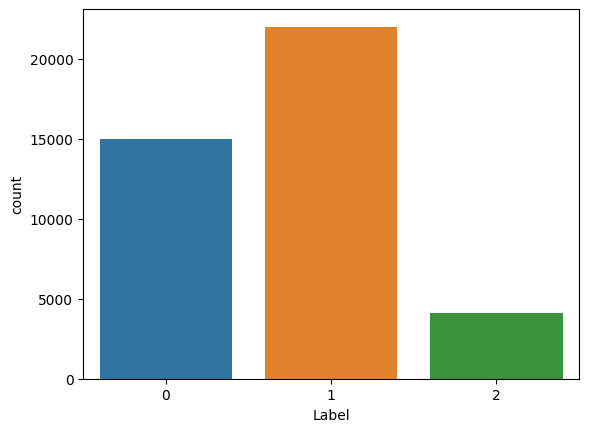

In [ ]:
sns.countplot(x=df['Label'])

From above count plot we can notice that there is an class imbalance present in the dataset such that we have comparable instance in safe (0) and phishing (1) category but have significantly less instances in the malware (2) category

 **Variance Analysis**

Typically Features having more variance are considered to be more important as they capture more variability over the dataset and hence capture more information about the dataset

In [ ]:
# Top 5 features with highest variance are 🇰
df.var().sort_values(ascending=False).head()

<ipython-input-13-a421767c1b95>:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.var().sort_values(ascending = False).head()


getLength       33379.662710
numDigit          657.393703
num_Imag          539.267892
Sp_Character       13.771907
domainAge           4.749516
dtype: float64

getLength, numDigit, num_Imag, Sp_Character, domainAge seem to have the highest variance

Handing Missing Values

In [ ]:
df.isnull().sum()

havingIP                     0
haveAtSign                   0
countDot                     0
prefixSuffix                 0
redirection                  0
httpDomain                   0
tinyURL                      0
getLength                    0
getSlash                     0
numDigit                     0
numfragments                 0
numsubdomain                 0
domainExt                   13
URL_Shannon_Entropy          0
Domain_Shannon_Entropy       0
Path_Shannon_Entropy         0
Query_Shannon_Entropy        0
QandP_Shannon_Entropy        0
Susp_ext                     0
space preset                 0
digitToLetter_ratio          0
Sp_Character                 0
susp_words                   0
domainAge                    0
domainCountry              137
num_Imag                  8055
iframe                       0
Mouse_Over                   0
Label                        0
dtype: int64

domainExt has 13 missing values, domainCountry has 137 missing values and num_Imag has 8055 missing values. These missing values are the result of who is not being able to establies connect or fetch information about these sites before the timeout.

In [ ]:
# Imputing missing county domains with N/A
df["domainCountry"].fillna("N/A", inplace=True)

In [ ]:
df.groupby("Label")['num_Imag'].value_counts().nlargest(30).unstack(fill_value=0)

num_Imag,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,19.0,22.0,87.0,88.0
Label,,,,,,,,,,,,,,,,,,,,,
0,3962,669,651,396,259,289,237,322,193,179,...,130,133,135,123,151,103,184,85,368,180
1,12390,3942,799,425,188,169,0,0,0,153,...,0,0,0,0,0,0,0,0,0,0
2,3659,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# mean appears to be very high for safe pages
# and does not not look like the correct value to be used for imputation
df.groupby("Label")['num_Imag'].mean()

Label
0    15.112745
1     1.140988
2     0.208742
Name: num_Imag, dtype: float64

In [ ]:
medians = df.groupby("Label")['num_Imag'].transform('median')
medians

0       3.0
1       3.0
2       3.0
3       3.0
4       3.0
       ... 
4073    0.0
4074    0.0
4075    0.0
4076    0.0
4077    0.0
Name: num_Imag, Length: 41078, dtype: float64

In [ ]:
# Imputing missing number of images with median
df['num_Imag'].fillna(medians, inplace=True)

In [ ]:
# shuffling the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Finding non-numeric features features
num_cols = df._get_numeric_data().columns
cate_cols = list(set(df.columns) - set(num_cols))
cate_cols

['domainExt', 'domainCountry']

['domainExt', 'domainCountry'] are two non-numeric features

In [ ]:
df['domainExt'].value_counts()[:20]

com        17739
html        3851
m           1615
org         1614
app         1243
htm         1203
io          1018
php          985
network      853
a            785
net          722
uk           649
link         633
edu          491
co           438
dev          400
top          274
sh           270
site         257
p            227
Name: domainExt, dtype: int64

In [ ]:
# Grouping domain extensions based on labels (for analysis purpose)
df.groupby("Label")['domainExt'].value_counts().nlargest(30).unstack(fill_value=0)

domainExt,a,app,au,ca,co,com,dev,edu,htm,html,...,net,network,org,p,php,sh,site,top,uk,xyz
Label,,,,,,,,,,,,,,,,,,,,,
0,0,0,181,158,0,7026,0,491,1089,1671,...,562,0,1427,0,0,0,0,0,634,0
1,0,1243,0,0,434,10570,400,0,0,2180,...,150,853,176,227,717,0,256,274,0,155
2,785,0,0,0,0,143,0,0,0,0,...,0,0,0,0,188,258,0,0,0,0


We can notice some extensions are specific to a particular class like .app, .dev, .network is only seen in phisihing URLs , .a is only seen in malware URLs, .edu is only seen in safe URLs and therefore this feature can act as a strong feature for distinguishing between the different URL classes.

In [ ]:
# Common extensions observed for malcious links
ext = ['m', 'a', 'i', 'sh', 'exe']

# Creating new feature for the same
df['hasMalwExt'] = [1 if x in ext else 0 for x in df['domainExt']]

# Similarly creating more features based on extension
ext = ['php']
df['hasPHPext'] = [1 if x in ext else 0 for x in df['domainExt']]

ext = ['htm']
df['hasHTMext'] = [1 if x in ext else 0 for x in df['domainExt']]

ext = ['html']
df['hasHTMLext'] = [1 if x in ext else 0 for x in df['domainExt']]


In [ ]:
df1 = df

Plotting box plot for different numeric features to visualize the distributions of different features and identify features for which the 3 classes have significant different distribution. Such features can also act as strong indicators for classification.

Text(0.5, 1.0, 'Box Plot for digitToLetter_ratio')

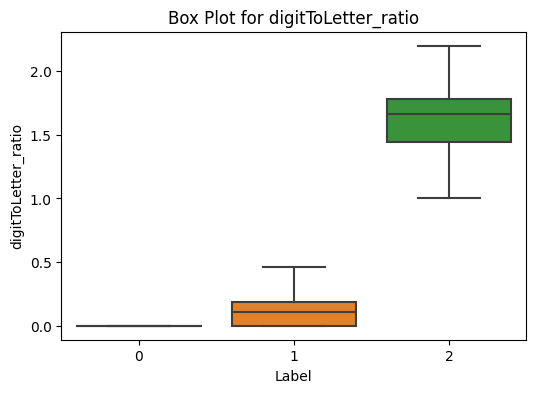

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df1['digitToLetter_ratio'], x=df1['Label'], showfliers=False)
plt.title("Box Plot for digitToLetter_ratio")

'digitToLetter_ratio' seems to have significantly different distribution for the 3 classes and hence this may be used as a strong predictor for classification.

Text(0.5, 1.0, 'Box Plot for Domain_Shannon_Entropy')

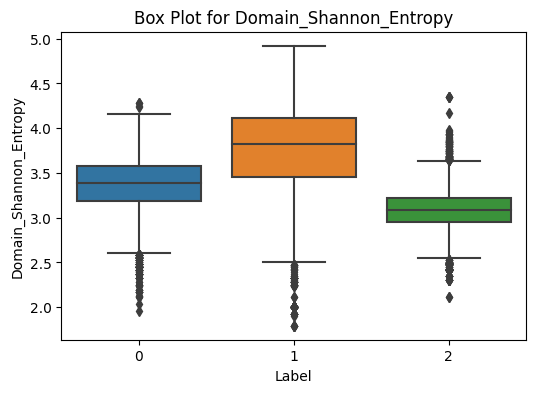

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df1['Domain_Shannon_Entropy'], x=df1['Label'])
plt.title("Box Plot for Domain_Shannon_Entropy")

'Domain_Shannon_Entropy' seems to have comparable/similar distribution for the 3 classes and hence this may act as a weak predictor for classification.

Text(0.5, 1.0, 'Box Plot for getLength')

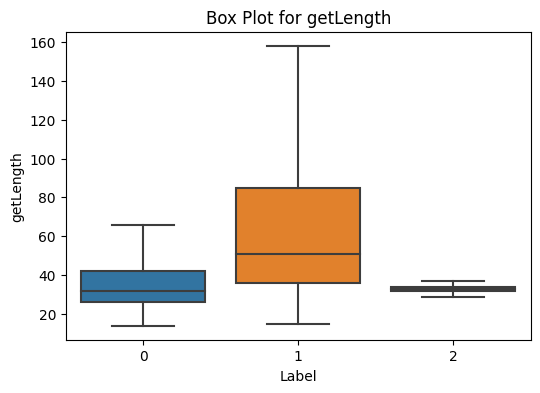

In [ ]:
plt.figure(figsize=(6, 4))

sns.boxplot(y=df1['getLength'], x=df1['Label'], showfliers=False)

plt.title("Box Plot for getLength")

'getLength' seems to have comparable/similar distribution for the class 0 and 2 which are different from that of class 1 and hence this may be used to identify phishing urls.

Text(0.5, 1.0, 'Box Plot for numDigit')

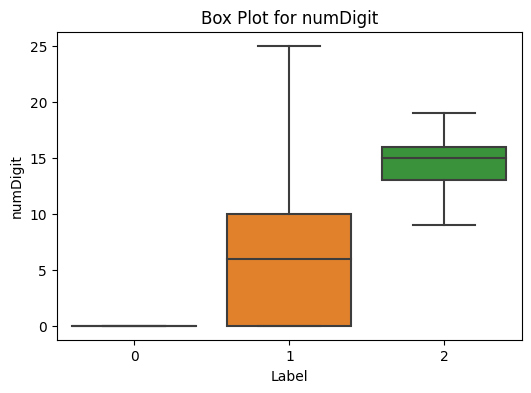

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df1['numDigit'], x=df1['Label'], showfliers=False)
plt.title("Box Plot for numDigit")

safe url seem to have significantly lower number of digits in the url than phishing and malware urls and hence may be used as a strong predictor for identifying safe urls.

Text(0.5, 1.0, 'Box Plot for numsubdomain')

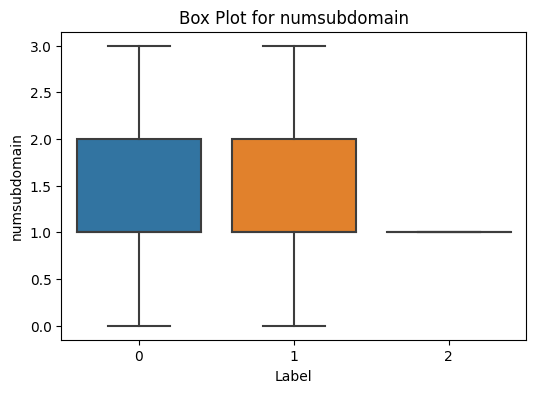

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df1['numsubdomain'], x=df1['Label'], showfliers=False)
plt.title("Box Plot for numsubdomain")

malware url seem to have significantly lower sub domains in the url than phishing and malware urls and hence may be used as a strong predictor for identifying malare.

Text(0.5, 1.0, 'Box Plot for Path_Shannon_Entropy')

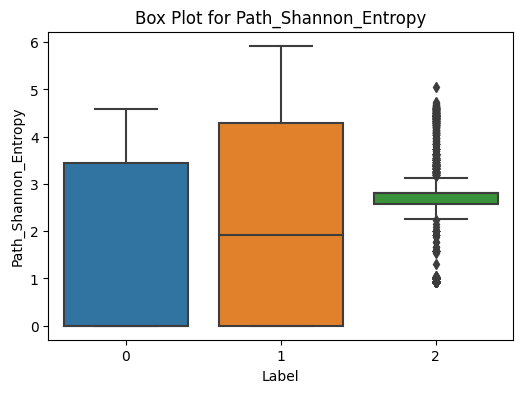

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df1['Path_Shannon_Entropy'], x=df1['Label'])
plt.title("Box Plot for Path_Shannon_Entropy")

Text(0.5, 1.0, 'Box Plot for URL_Shannon_Entropy')

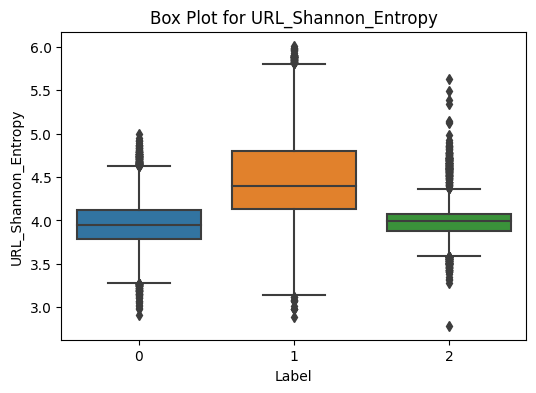

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df1['URL_Shannon_Entropy'], x=df1['Label'])
plt.title("Box Plot for URL_Shannon_Entropy")

'URL_Shannon_Entropy' seems to have comparable/similar distribution for the 3 classes and hence this may act as a weak predictor for classification.

In [ ]:
df.columns

Index(['havingIP', 'haveAtSign', 'countDot', 'prefixSuffix', 'redirection',
       'httpDomain', 'tinyURL', 'getLength', 'getSlash', 'numDigit',
       'numfragments', 'numsubdomain', 'domainExt', 'URL_Shannon_Entropy',
       'Domain_Shannon_Entropy', 'Path_Shannon_Entropy',
       'Query_Shannon_Entropy', 'QandP_Shannon_Entropy', 'Susp_ext',
       'space preset', 'digitToLetter_ratio', 'Sp_Character', 'susp_words',
       'domainAge', 'domainCountry', 'num_Imag', 'iframe', 'Mouse_Over',
       'Label', 'hasMalwExt', 'hasPHPext', 'hasHTMext', 'hasHTMLext'],
      dtype='object')

Preparing the Input

In [ ]:
feature_names = ['havingIP', 'haveAtSign', 'countDot', 'prefixSuffix',
                 'tinyURL', 'getLength', 'getSlash',
                 'numDigit', 'numsubdomain',
                 'URL_Shannon_Entropy', 'Domain_Shannon_Entropy', 'Path_Shannon_Entropy',
                 'Query_Shannon_Entropy', 'QandP_Shannon_Entropy',
                 'digitToLetter_ratio', 'Sp_Character', 'susp_words',
                 'num_Imag', 'iframe', 'Mouse_Over', 'hasMalwExt', 'hasHTMext', 'hasHTMLext', 'hasPHPext',
                 ]

sc = MinMaxScaler()

X = df[feature_names]
X = pd.DataFrame(sc.fit_transform(X))
y = df["Label"]
from pickle import dump

dump(sc, open('scaler.pkl', 'wb'))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.015873,1.0,0.0,0.001137,0.000000,0.000000,0.055556,0.389228,...,0.000000,0.018519,1.0,0.001609,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.031746,0.0,0.0,0.006900,0.416667,0.005274,0.277778,0.837989,...,0.031032,0.135802,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.031746,0.0,0.0,0.000470,0.000000,0.000000,0.055556,0.327655,...,0.000000,0.018519,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.031746,0.0,0.0,0.001215,0.166667,0.000000,0.111111,0.396545,...,0.000000,0.024691,0.0,0.001609,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.031746,0.0,0.0,0.002901,0.000000,0.003223,0.000000,0.668650,...,0.038996,0.012346,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(feature_names)

24

In [ ]:
y.value_counts()

1    22000
0    15000
2     4078
Name: Label, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts()

1    17660
0    11904
2     3298
Name: Label, dtype: int64

Training and tuning ML models

In [ ]:
X.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int64

In [ ]:
# Define the models and their parameter grids for GridSearchCV
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1500), {'C': [0.01, 0.1, 1, 10, 100]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [2, 5, 10, 20]}),
    'Random Forest': (RandomForestClassifier(), {'max_depth': [2, 5, 10, 20], 'n_estimators': [50, 100, 200]}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'XG Boost': (XGBClassifier(), {'max_depth': [2, 5, 10, 20], 'n_estimators': [50, 100, 200]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9, 25]})
}

# Results storage
results = {
    'Model': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Confusion Matrix': [],
    'Classification Report': []
}

# Train and evaluate each model with GridSearchCV
for model_name, (model, param_grid) in models.items():
    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Best parameters after GridSearchCV
    best_params = grid_search.best_params_
    
    # Train the model with the best parameters
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    cm = confusion_matrix(y_test, y_test_pred)
    report = classification_report(y_test, y_test_pred, target_names=['class_0', 'class_1',
                                                                      'class_2'])  # Modify the target_names accordingly

    # Store results
    results['Model'].append(model_name)
    results['Train Accuracy'].append(train_accuracy)
    results['Test Accuracy'].append(test_accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    results['Confusion Matrix'].append(cm)
    results['Classification Report'].append(report)

    print(f"\n\n{model_name} - Best Parameters: {best_params}")





Logistic Regression - Best Parameters: {'C': 100}


Decision Tree - Best Parameters: {'max_depth': 20}


Random Forest - Best Parameters: {'max_depth': 20, 'n_estimators': 200}


SVM - Best Parameters: {'C': 10, 'kernel': 'rbf'}


XG Boost - Best Parameters: {'max_depth': 5, 'n_estimators': 100}


KNN - Best Parameters: {'n_neighbors': 3}


**Experimenting with GloVe Embeddings + Neural Network.**

In [ ]:
benign = pd.read_csv('RawDatasets/benignDMOZ.csv')
benign['label'] = 0
benign = benign[['url', 'label']]

phish = pd.read_csv('RawDatasets/verified_phishing_online.csv')
phish['label'] = 1
phish = phish[['url', 'label']].iloc[:22000]

mal = pd.read_csv('RawDatasets/malwareOnline.csv')
mal['label'] = 2
mal = mal[['url', 'label']].iloc[:4078]

In [ ]:
df = pd.concat([benign, phish, mal], axis=0)
df

,url,label
0,http://www.bare-co.com,0
1,http://www.abccables.com/,0
2,http://www.nipponcrystal.com,0
3,http://www.roberthudson.org/,0
4,http://movies.yahoo.com/shop?d=hc&amp;id=18000...,0
...,...,...
4073,http://198.12.84.79/20090/vbc.exe,2
4074,http://112.249.113.80:60452/i,2
4075,http://49.89.72.154:55259/Mozi.m,2
4076,http://39.82.94.81:38801/Mozi.m,2


In [ ]:
df = shuffle(df)

# Tokenize the URLs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['url'])

# Convert URLs to sequences
sequences = tokenizer.texts_to_sequences(df['url'])

# Pad sequences to have the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
one_hot_labels = to_categorical(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

In [ ]:
def model1(embedding_matrix):
    inputs1 = Input(shape=(max_length,))

    embedding1 = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, weights=[embedding_matrix],
                           input_length=max_length, trainable=False)(inputs1)
    flat = Flatten()(embedding1)

    dense1 = Dense(128, activation='relu')(flat)
    dense2 = Dense(32, activation='relu')(dense1)
    outputs = Dense(3, activation='softmax')(dense2)

    model = Model(inputs=[inputs1], outputs=outputs)
    return model

Using Pretraining + Fine Tunig for better results

In [ ]:
glove_model = load('glove-wiki-gigaword-300')

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]

model_pretrained_embb = model1(embedding_matrix)

# Compile the model
model_pretrained_embb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_pretrained_embb.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1027/1027 [==============================] - 6s 5ms/step - loss: 0.0774 - accuracy: 0.9717 - val_loss: 0.0632 - val_accuracy: 0.9765
Epoch 2/10
1027/1027 [==============================] - 6s 6ms/step - loss: 0.0461 - accuracy: 0.9832 - val_loss: 0.0568 - val_accuracy: 0.9798
Epoch 3/10
1027/1027 [==============================] - 7s 7ms/step - loss: 0.0370 - accuracy: 0.9866 - val_loss: 0.0724 - val_accuracy: 0.9805
Epoch 4/10
1027/1027 [==============================] - 5s 5ms/step - loss: 0.0321 - accuracy: 0.9880 - val_loss: 0.0629 - val_accuracy: 0.9811
Epoch 5/10
1027/1027 [==============================] - 6s 6ms/step - loss: 0.0303 - accuracy: 0.9887 - val_loss: 0.0650 - val_accuracy: 0.9822
Epoch 6/10
1027/1027 [==============================] - 5s 5ms/step - loss: 0.0260 - accuracy: 0.9903 - val_loss: 0.0697 - val_accuracy: 0.9821
Epoch 7/10
1027/1027 [==============================] - 6s 6ms/step - loss: 0.0240 - accuracy: 0.9914 - val_loss: 0.0750 - val_accuracy:

In [ ]:
y_pred = model_pretrained_embb.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

train_accuracy = model_pretrained_embb.evaluate(X_train, y_train, verbose=0)[1]
test_accuracy = model_pretrained_embb.evaluate(X_test, y_test, verbose=0)[1]
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
cm = confusion_matrix(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

results['Model'].append("Pretrained Embeddings")
results['Train Accuracy'].append(train_accuracy)
results['Test Accuracy'].append(test_accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1 Score'].append(f1)
results['Confusion Matrix'].append(cm)
results['Classification Report'].append(report)

257/257 [==============================] - 1s 2ms/step


Using Dataset specific GloVe embeddings

In [ ]:
# Word2Vec embeddings trained on our dataset
word2vec_model = Word2Vec(sentences=df['url'].apply(lambda x: x.split()), vector_size=300, window=5, min_count=1,
                          workers=4)
word2vec_embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        word2vec_embedding_matrix[i] = word2vec_model.wv[word]

model_embb = model1(word2vec_embedding_matrix)

# Compile the model
model_embb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model
model_embb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_embb.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
822/822 [==============================] - 11s 10ms/step - loss: 0.5598 - accuracy: 0.5414 - val_loss: 0.5368 - val_accuracy: 0.5571
Epoch 2/10
822/822 [==============================] - 5s 6ms/step - loss: 0.5348 - accuracy: 0.5534 - val_loss: 0.5327 - val_accuracy: 0.5571
Epoch 3/10
822/822 [==============================] - 5s 6ms/step - loss: 0.5339 - accuracy: 0.5536 - val_loss: 0.5320 - val_accuracy: 0.5573
Epoch 4/10
822/822 [==============================] - 5s 6ms/step - loss: 0.5338 - accuracy: 0.5538 - val_loss: 0.5320 - val_accuracy: 0.5573
Epoch 5/10
822/822 [==============================] - 4s 5ms/step - loss: 0.5337 - accuracy: 0.5538 - val_loss: 0.5320 - val_accuracy: 0.5574
Epoch 6/10
822/822 [==============================] - 4s 5ms/step - loss: 0.5335 - accuracy: 0.5538 - val_loss: 0.5320 - val_accuracy: 0.5573
Epoch 7/10
822/822 [==============================] - 6s 7ms/step - loss: 0.5334 - accuracy: 0.5538 - val_loss: 0.5325 - val_accuracy: 0.5573
Epoc

In [ ]:
y_pred = model_embb.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

train_accuracy = model_embb.evaluate(X_train, y_train, verbose=0)[1]
test_accuracy = model_embb.evaluate(X_test, y_test, verbose=0)[1]
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
cm = confusion_matrix(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

results['Model'].append("Normal Embeddings")
results['Train Accuracy'].append(train_accuracy)
results['Test Accuracy'].append(test_accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1 Score'].append(f1)
results['Confusion Matrix'].append(cm)
results['Classification Report'].append(report)

In [ ]:
df_results = pd.DataFrame(results)
df_results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Confusion Matrix,Classification Report
0,Logistic Regression,0.882326,0.875365,0.876011,0.875365,0.875584,"[[2676, 417, 3], [489, 3808, 43], [15, 57, 708]]",precision recall f1-score ...
1,Decision Tree,0.985698,0.937074,0.937274,0.937074,0.937118,"[[2881, 213, 2], [266, 4053, 21], [4, 11, 765]]",precision recall f1-score ...
2,Random Forest,0.987828,0.954966,0.955211,0.954966,0.955038,"[[2947, 149, 0], [204, 4133, 3], [3, 11, 766]]",precision recall f1-score ...
3,SVM,0.911630,0.904576,0.908053,0.904576,0.905072,"[[2863, 229, 4], [524, 3810, 6], [4, 17, 759]]",precision recall f1-score ...
4,XG Boost,0.970117,0.954601,0.954822,0.954601,0.954659,"[[2943, 153, 0], [208, 4127, 5], [3, 4, 773]]",precision recall f1-score ...
5,KNN,0.946412,0.907376,0.908405,0.907376,0.907626,"[[2791, 303, 2], [432, 3898, 10], [7, 7, 766]]",precision recall f1-score ...
6,Pretrained Embeddings,0.992240,0.977848,0.977921,0.977848,0.977812,"[[2897, 116, 3], [48, 4328, 5], [6, 4, 809]]",precision recall f1-score ...
7,Normal Embeddings,0.556113,0.551120,0.383242,0.551120,0.406071,"[[0, 3010, 6], [0, 4377, 4], [0, 668, 151]]",precision recall f1-score ...


In [ ]:
df_results.to_csv('drive/MyDrive/malTrack/train_results.csv')

In [ ]:
df_results = pd.read_csv('drive/MyDrive/malTrack/train_results.csv')

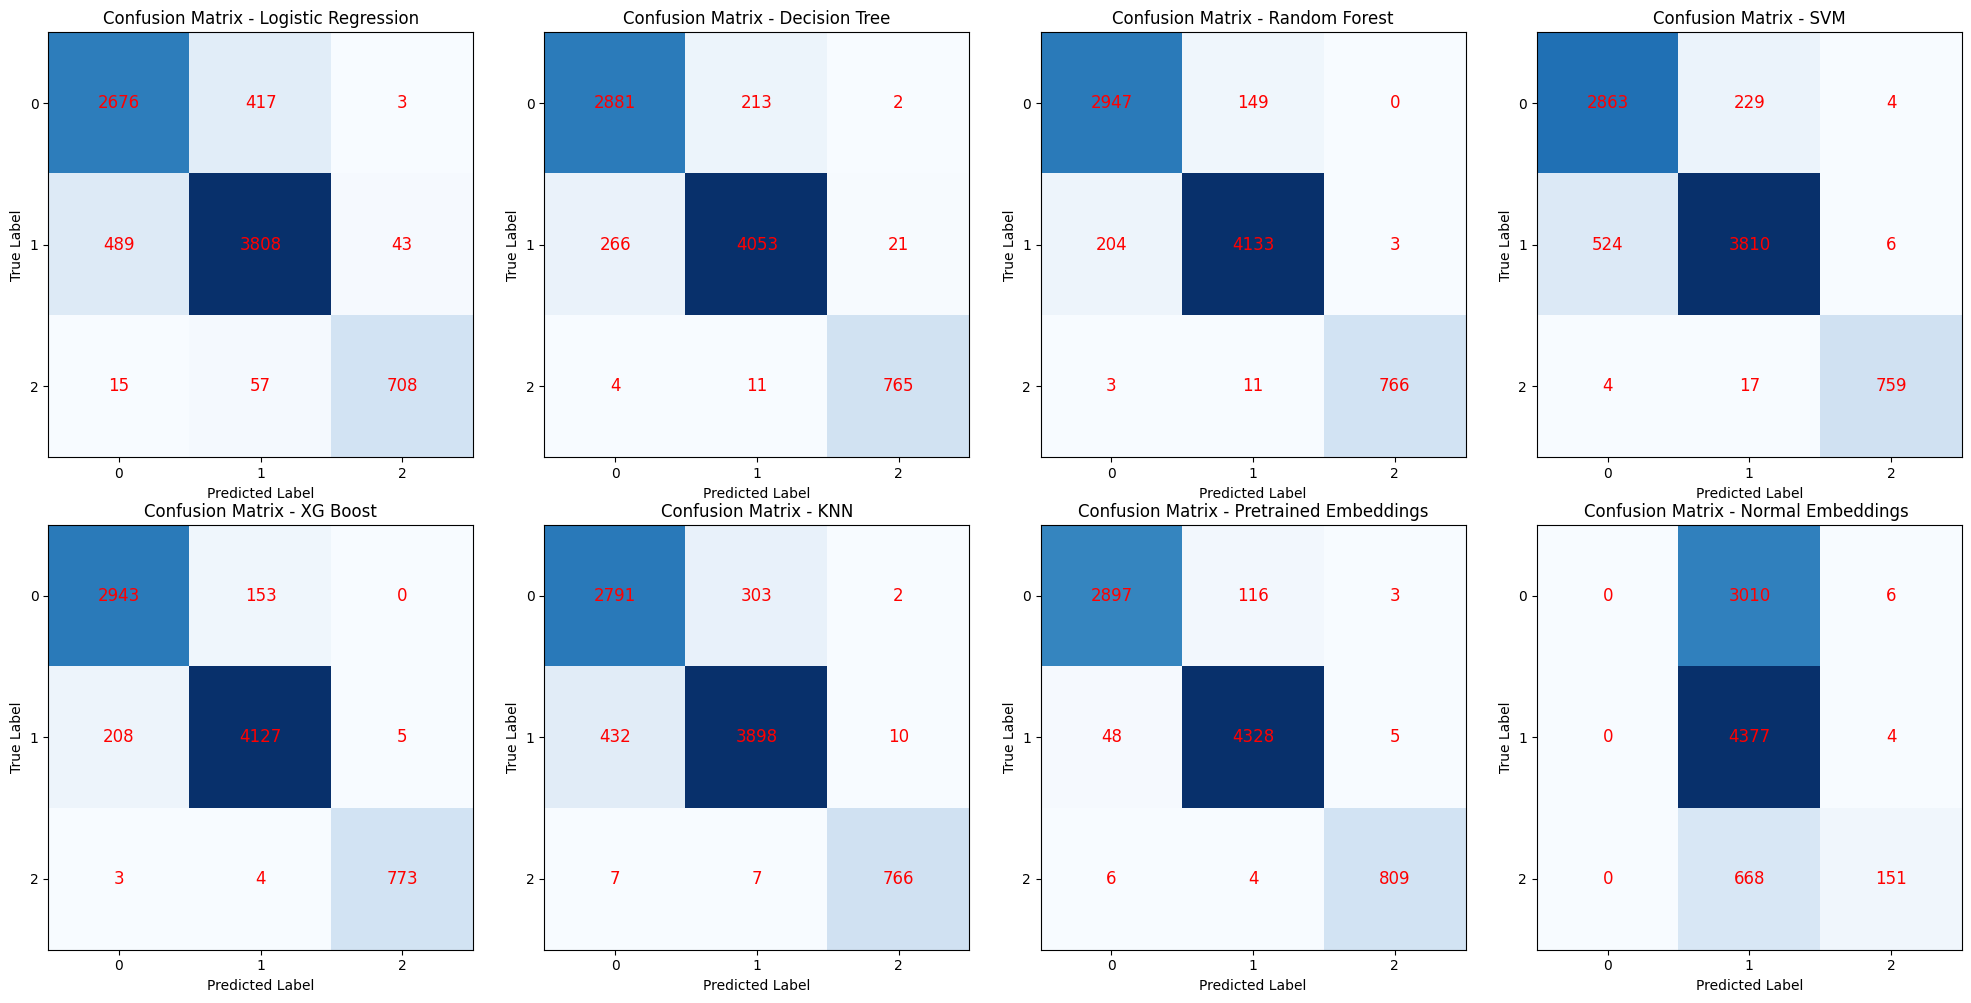

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
model_names = list(models.keys())
model_names.append("Pretrained Embeddings")
model_names.append("Normal Embeddings ")

for i, (model_name, cm) in enumerate(zip(model_names, results['Confusion Matrix'])):
    row, col = divmod(i, 4)
    ax = axes[row, col]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix - {model_name}')
    tick_marks = np.arange(3)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Add counts to the confusion matrix
    for i in range(len(tick_marks)):
        for j in range(len(tick_marks)):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='red', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
df_results[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']]

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.882326,0.875365,0.876011,0.875365,0.875584
1,Decision Tree,0.985698,0.937074,0.937274,0.937074,0.937118
2,Random Forest,0.987828,0.954966,0.955211,0.954966,0.955038
3,SVM,0.911630,0.904576,0.908053,0.904576,0.905072
4,XG Boost,0.970117,0.954601,0.954822,0.954601,0.954659
5,KNN,0.946412,0.907376,0.908405,0.907376,0.907626
6,Pretrained Embeddings,0.992240,0.977848,0.977921,0.977848,0.977812
7,Normal Embeddings,0.556113,0.551120,0.383242,0.551120,0.406071


In [ ]:
for i, report in df_results[['Model', 'Classification Report']].values:
    print(i)
    print(report)

Logistic Regression
              precision    recall  f1-score   support

     class_0       0.84      0.86      0.85      3096
     class_1       0.89      0.88      0.88      4340
     class_2       0.94      0.91      0.92       780

    accuracy                           0.88      8216
   macro avg       0.89      0.88      0.89      8216
weighted avg       0.88      0.88      0.88      8216

Decision Tree
              precision    recall  f1-score   support

     class_0       0.91      0.93      0.92      3096
     class_1       0.95      0.93      0.94      4340
     class_2       0.97      0.98      0.98       780

    accuracy                           0.94      8216
   macro avg       0.94      0.95      0.95      8216
weighted avg       0.94      0.94      0.94      8216

Random Forest
              precision    recall  f1-score   support

     class_0       0.93      0.95      0.94      3096
     class_1       0.96      0.95      0.96      4340
     class_2       1.00    